In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
num_images = 1
img_dim = 16 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 8
psf_stdev = 3.25
background_intensity = 19200

prior = CatalogPrior(max_objects = max_objects,
                     img_height = img_height,
                     img_width = img_width,
                     min_flux = background_intensity/3.)

image_attributes = ImageAttributes(img_height = img_height,
                                   img_width = img_width,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(prior, num_images)

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")

image 1 
count
 5 
total flux
 310059.625 
loc
 [[ 5.2999854 14.183369 ]
 [ 2.8935199 11.932484 ]
 [10.297721   2.3781328]
 [ 9.657547   3.0498097]
 [ 5.11774   15.066838 ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]] 




True count: 5
True total flux: 310059.625
Naive estimated source count (true total flux / prior mean flux): 4.844681739807129

Starting the sampler...
iteration 5, temperature = 0.0014071406330913305, posterior mean count = 4.62787389755249
iteration 10, temperature = 0.0037299722898751497, posterior mean count = 4.336371421813965
iteration 15, temperature = 0.007591670379042625, posterior mean count = 4.382802963256836
iteration 20, temperature = 0.015145122073590755, posterior mean count = 4.527815341949463
iteration 25, temperature = 0.030918657779693604, posterior mean count = 5.238385200500488
iteration 30, temperature = 0.0735955759882927, posterior mean count = 5.162085056304932
iteration 35, temperature = 0.16922837495803833, posterior mean count = 5.075878620147705
iteration 40, temperature = 0.36921051144599915, posterior mean count = 5.002291679382324
iteration 45, temperature = 0.679955244064331, posterior mean count = 5.007290840148926
Done!

summary
number of SMC iteratio

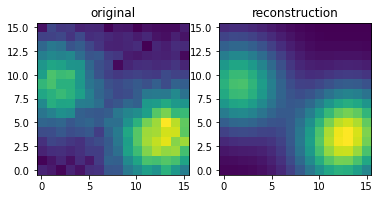

In [4]:
max_objects_smc = max_objects + 2
pad = 0
prior = CatalogPrior(max_objects_smc, img_width, img_height, background_intensity/3., pad)
smc = SMCsampler(images[0], image_attributes, prior,
                 num_blocks = max_objects_smc + 1, catalogs_per_block = 500,
                 max_smc_iters = 500,
                 wastefree = True, wastefree_M = 10)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}")
print(f"Naive estimated source count (true total flux / prior mean flux): {true_fluxes[0].sum() / prior.flux_prior.mean}\n")

smc.run(print_progress = True)
smc.summarize()